# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
# Load the training and testing data and labels from the dictionary
train_x, train_y, test_x, test_y = train['X'], train['y'], test['X'], test['y']
print(f'Training data shape: {train_x.shape}\n\
Training labels shape:{train_y.shape}\n\
Test data shape:{test_x.shape}\n\
Test labels shape:{test_y.shape}')

Training data shape: (32, 32, 3, 73257)
Training labels shape:(73257, 1)
Test data shape:(32, 32, 3, 26032)
Test labels shape:(26032, 1)


In [4]:
# Rearrange the train and test data to have number of examples 1st

train_x = np.moveaxis(train_x, -1, 0)
test_x = np.moveaxis(test_x, -1, 0)

# Print the shape of the data again
print(f'Training data shape: {train_x.shape}\n\
Training labels shape:{train_y.shape}\n\
Test data shape:{test_x.shape}\n\
Test labels shape:{test_y.shape}')

Training data shape: (73257, 32, 32, 3)
Training labels shape:(73257, 1)
Test data shape:(26032, 32, 32, 3)
Test labels shape:(26032, 1)


In [5]:
# Replace the class label 10 to 0
test_y[test_y==10] = 0
train_y[train_y==10] = 0

In [6]:
# Helper function to convert color images to gray and normalize it.
def color_to_normalized_gray(arr):
    """Convert array of colored images to gray and normalize it's values
       by dividing by 255.
       baram: arr: numpy array of shape(num_images, height, width, 3)
       return normailized array of gray images.
    """
    gray_images = np.mean(arr, 3, keepdims=True) / 255
    return gray_images

In [7]:
train_x_gray = color_to_normalized_gray(train_x)
test_x_gray = color_to_normalized_gray(test_x)
# Print the shape of the data again
print(f'New training data shape: {train_x_gray.shape}\n\
New est data shape:{test_x_gray.shape}\n')

New training data shape: (73257, 32, 32, 1)
New est data shape:(26032, 32, 32, 1)



In [54]:
def plot_images(images, nrows, ncols, true_labels, predictions=None):
    """ Helper function for plotting nrows * ncols images
        param: images: array of images to plot
        param: nrows: number of rows in the subplot
        param: ncols: number of columns in the subplot
        param: true_labels: true label values of the images
        param: predictions: predicted labels of the images
        return None
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat):           
        if images[i].shape == (32, 32, 3):
            ax.imshow(images[i])
        else:
            ax.imshow(images[i,:,:,0], cmap="gray")
            
        if predictions is None:
            title = f"Label: {str(true_labels[i])}"
            ax.set_title(title, color='b')
        elif predictions[i] == true_labels[i]:
            title = f"Label: {str(true_labels[i])}, Pred: [{str(predictions[i])}]"
            ax.set_title(title, color='g')              
        else:
            title = f"Label: {str(true_labels[i])}, Pred: [{str(predictions[i])}]"
            ax.set_title(title, color='r')
          
        ax.set_xticks([]); ax.set_yticks([])

Training Examples


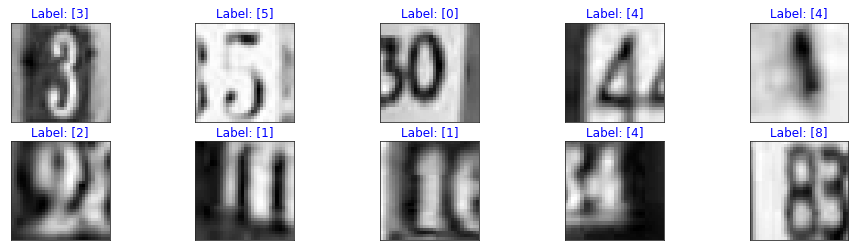

In [9]:
np.random.seed(0)
idx_train = np.random.choice(train_x_gray.shape[0]-1, 10)
print('Training Examples')
plot_images(train_x_gray[idx_train], 2, 5, train_y[idx_train])

Test Examples


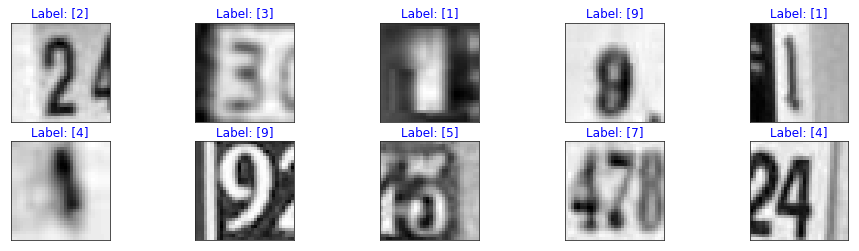

In [10]:
# get random indices for test
np.random.seed(0)
idx_test = np.random.choice(test_x_gray.shape[0]-1, 10)
print('Test Examples')
plot_images(train_x_gray[idx_test], 2, 5, train_y[idx_test])

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [11]:
# Create MLP model
def get_mlp_model():
    mlp_model = Sequential([
                            Flatten(input_shape=train_x_gray[0].shape),
                            Dense(512, activation='relu'),
                            Dense(256, activation='relu'),
                            BatchNormalization(),
                            Dense(128, activation='relu'),
                            Dropout(0.3),
                            Dense(64, activation='relu'),
                            Dense(10, activation='softmax')
    ])
    return mlp_model

In [12]:
mlp_model = get_mlp_model()

In [13]:
# Print model summary
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [14]:
# Compile the model
mlp_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:
# Create call backs
checkpoint = ModelCheckpoint(filepath='mlp_model.h5',
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

early_stop = EarlyStopping(patience=5,
                           monitor='loss',
                           mode='min')

In [16]:
# Train the model
history = mlp_model.fit(train_x_gray,
                        train_y,
                        epochs=30,
                        validation_data=(test_x_gray, test_y),
                        batch_size=128,
                        callbacks=[checkpoint, early_stop])

Train on 73257 samples, validate on 26032 samples
Epoch 1/30
73088/73257 [============================>.] - ETA: 0s - loss: 1.5366 - accuracy: 0.4853
Epoch 00001: val_loss improved from inf to 1.93162, saving model to mlp_model.h5
73257/73257 [==============================] - 54s 743us/sample - loss: 1.5357 - accuracy: 0.4856 - val_loss: 1.9316 - val_accuracy: 0.3970
Epoch 2/30
73088/73257 [============================>.] - ETA: 0s - loss: 1.1423 - accuracy: 0.6446
Epoch 00002: val_loss did not improve from 1.93162
73257/73257 [==============================] - 51s 691us/sample - loss: 1.1426 - accuracy: 0.6445 - val_loss: 2.0967 - val_accuracy: 0.3701
Epoch 3/30
73216/73257 [============================>.] - ETA: 0s - loss: 1.0430 - accuracy: 0.6790
Epoch 00003: val_loss improved from 1.93162 to 1.24688, saving model to mlp_model.h5
73257/73257 [==============================] - 52s 705us/sample - loss: 1.0429 - accuracy: 0.6790 - val_loss: 1.2469 - val_accuracy: 0.6157
Epoch 4/30
73

In [17]:
df = pd.DataFrame(history.history)
df.tail(10)

,loss,accuracy,val_loss,val_accuracy
20,0.627882,0.803882,0.818059,0.753112
21,0.623861,0.805534,0.752738,0.769937
22,0.611547,0.809834,0.873165,0.737938
23,0.606681,0.810475,0.864296,0.733059
24,0.602679,0.811690,0.771441,0.764444
25,0.594544,0.815403,0.798895,0.757337
26,0.595085,0.813615,0.794255,0.756262
27,0.590590,0.815485,0.799262,0.764290
28,0.584902,0.818215,0.807464,0.755186
29,0.575650,0.819594,0.787290,0.759949


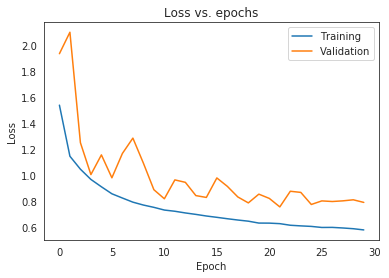

In [18]:
# Plot the loss for training and validation sets
plt.plot(df.loss)
plt.plot(df.val_loss)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

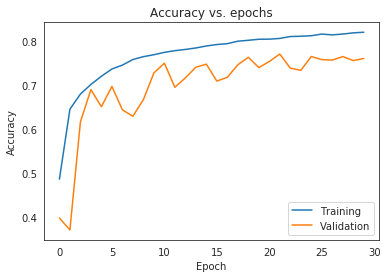

In [19]:
# Plot the accuracy for training and validation sets
plt.plot(df.accuracy)
plt.plot(df.val_accuracy)
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [20]:
test_loss, test_acc = mlp_model.evaluate(test_x_gray, test_y, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.787
Test accuracy: 75.99%


In [21]:
# Load the best model
mlp_best = get_mlp_model()
mlp_best.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [22]:
# Compile the model
mlp_best.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
mlp_best.load_weights('mlp_model.h5')

In [23]:
test_loss, test_acc = mlp_best.evaluate(test_x_gray, test_y, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.753
Test accuracy: 76.99%


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [24]:
cnn_model = Sequential([
                        Conv2D(16, 3, padding='SAME', activation='relu', input_shape=train_x_gray[0].shape),
                        MaxPooling2D(2),
                        BatchNormalization(),
                        Dropout(0.3),
                        Conv2D(32, 3, padding='SAME', activation='relu'),
                        MaxPooling2D(2),
                        BatchNormalization(),
                        Conv2D(64, 3, padding='SAME', activation='relu'),
                        MaxPooling2D(2),
                        Dropout(0.3),
                        Flatten(),
                        Dense(64, activation='relu'),
                        Dense(10, activation='softmax')
])

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 32)         

In [25]:
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [26]:
checkpoint_cnn = ModelCheckpoint(filepath='CNN.h5',
                                 save_best_only=True,
                                 save_weights_only=False,
                                 monitor='val_accuracy',
                                 mode='max',
                                 verbose=1)
early_stop_cnn = EarlyStopping(monitor='loss', patience=5, verbose=1)

In [27]:
history_cnn = cnn_model.fit(train_x_gray,
                        train_y,
                        callbacks=[checkpoint_cnn, early_stop_cnn],
                        batch_size=128,
                        validation_data=(test_x_gray, test_y),
                        epochs=30)

Train on 73257 samples, validate on 26032 samples
Epoch 1/30
73216/73257 [============================>.] - ETA: 0s - loss: 1.2097 - accuracy: 0.5945
Epoch 00001: val_accuracy improved from -inf to 0.76721, saving model to CNN.h5
73257/73257 [==============================] - 367s 5ms/sample - loss: 1.2094 - accuracy: 0.5946 - val_loss: 0.7987 - val_accuracy: 0.7672
Epoch 2/30
73216/73257 [============================>.] - ETA: 0s - loss: 0.5900 - accuracy: 0.8188
Epoch 00002: val_accuracy improved from 0.76721 to 0.86497, saving model to CNN.h5
73257/73257 [==============================] - 352s 5ms/sample - loss: 0.5899 - accuracy: 0.8189 - val_loss: 0.4890 - val_accuracy: 0.8650
Epoch 3/30
73216/73257 [============================>.] - ETA: 0s - loss: 0.4903 - accuracy: 0.8516
Epoch 00003: val_accuracy improved from 0.86497 to 0.87846, saving model to CNN.h5
73257/73257 [==============================] - 349s 5ms/sample - loss: 0.4903 - accuracy: 0.8516 - val_loss: 0.4181 - val_accu

In [28]:
df_cnn = pd.DataFrame(history_cnn.history)
df_cnn.tail(10)

,loss,accuracy,val_loss,val_accuracy
20,0.255262,0.922042,0.290167,0.919292
21,0.251078,0.922765,0.278119,0.923517
22,0.248052,0.923611,0.283485,0.921827
23,0.246316,0.924676,0.289625,0.919945
24,0.241195,0.924826,0.285024,0.922711
25,0.236968,0.926028,0.304888,0.914605
26,0.235690,0.926423,0.286659,0.920713
27,0.234709,0.925946,0.279802,0.925937
28,0.229093,0.927884,0.280062,0.925668
29,0.226215,0.929181,0.280152,0.925668


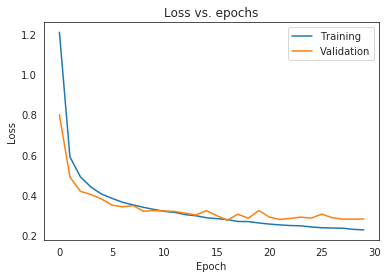

In [29]:
# Plot the loss for training and validation sets
plt.plot(df_cnn.loss)
plt.plot(df_cnn.val_loss)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

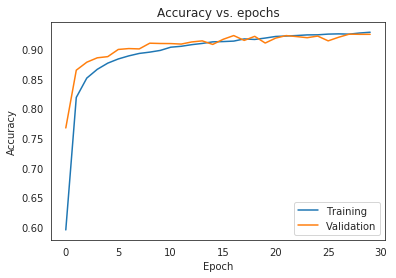

In [30]:
# Plot the accuracy for training and validation sets
plt.plot(df_cnn.accuracy)
plt.plot(df_cnn.val_accuracy)
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [31]:
test_loss, test_acc = cnn_model.evaluate(test_x_gray, test_y, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.280
Test accuracy: 92.57%


In [32]:
cnn_best = load_model('CNN.h5')
cnn_best.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 32)         

In [33]:
test_loss, test_acc = cnn_best.evaluate(test_x_gray, test_y, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.280
Test accuracy: 92.59%


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [34]:
# load MLP best model

# Create a new model with the same archeticture
mlp_best = get_mlp_model()

# Compile the model
mlp_best.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Load the model weights
mlp_best.load_weights('mlp_model.h5')

In [35]:
# Load CNN best model
cnn_best = load_model('CNN.h5')

In [36]:
# Get random indices for test
np.random.seed(0)
idx = np.random.choice(test_x_gray.shape[0]-1, 5)

# Get test images and labels
test_images = test_x_gray[idx]
test_labels = test_y[idx]

# Get MLP and CNN predictions for test images
mlp_predictions = mlp_best.predict(test_images)
cnn_predictions = cnn_best.predict(test_images)

MLP Test Examples


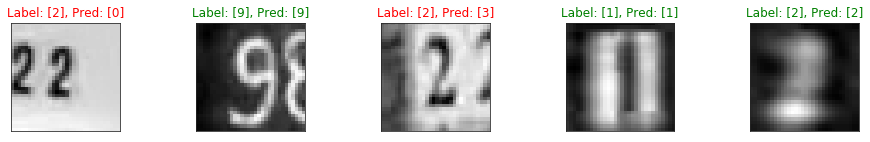

In [55]:
# Show the test images and the MLP model predictions
print('MLP Test Examples')
plot_images(test_images, 1, 5, test_labels, np.argmax(mlp_predictions, 1))

CNN Test Examples


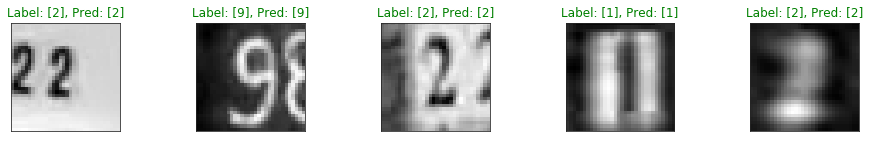

In [56]:
# Show the test images and the CNN model predictions
print('CNN Test Examples')
plot_images(test_images, 1, 5, test_labels, np.argmax(cnn_predictions, 1))

In [78]:
def plot_predictions(predictions, test_images, test_labels, title):
    """Function to plot the predictions and the categorical probabilty disturibution.
       param: predictions: array of shape (num_images, categories)
       param: test_images: test images to plot
       param: test_labels: true labels
       param: title: the kind of model for plot tutle
    """
    # Show the images and a bar chart with the predictions probabilty
    fig, axes = plt.subplots(5, 2, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)

    for i, (prediction, image, label) in enumerate(zip(predictions, test_images, test_labels)):
        predicted_label = np.argmax(prediction)
        image_title = f"Label: {label}, Pred: [{predicted_label}]"
        axes[i, 0].imshow(image[:, :, 0], cmap='gray')
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        if label == predicted_label:
            axes[i, 0].set_title(image_title, color='g')
        else:
            axes[i, 0].set_title(image_title, color='r')
        axes[i, 1].bar(np.arange(10), prediction)
        axes[i, 1].set_xticks(np.arange(10))
        axes[i, 1].set_title(f"Categorical Distribution ({title} Model Predictions)")

    plt.show()

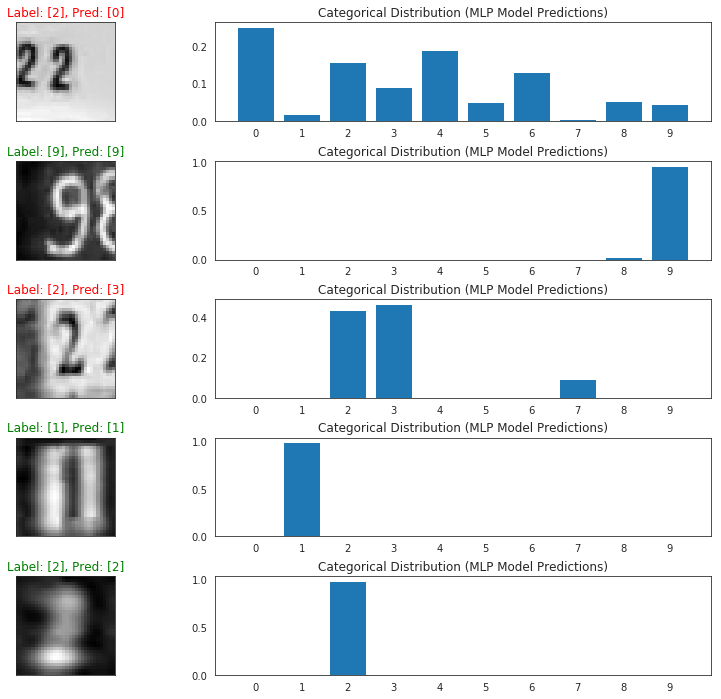

In [79]:
plot_predictions(mlp_predictions, test_images, test_labels, 'MLP')

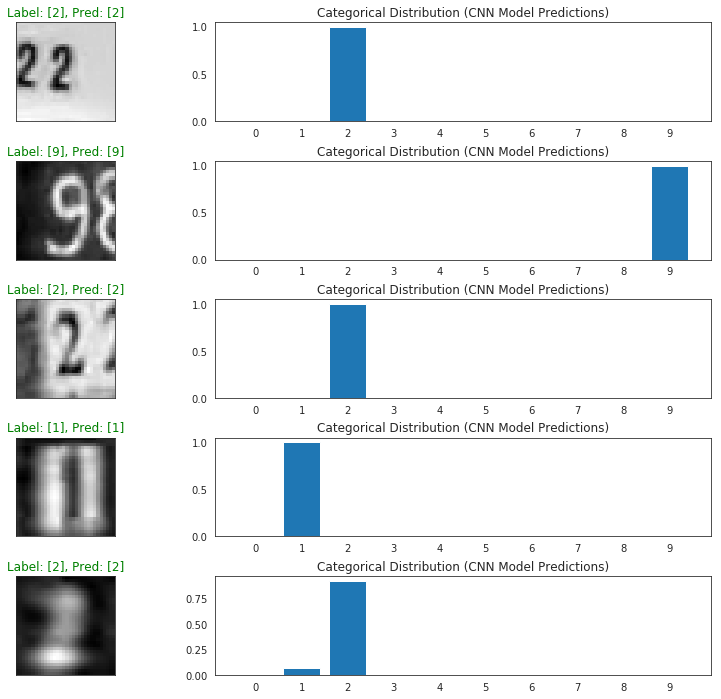

In [80]:
plot_predictions(cnn_predictions, test_images, test_labels, 'CNN')